# PointNet Transfer Learning on subset of ModelNet10


The ModelNet10 dataset contains 4899 3D Meshes from 10 different classes.

The classes are:

* bed
* monitor
* desk
* chair
* dresser
* toilet
* sofa
* table
* night stand
* bathttub 

We provide you a pretrained version of PointNet. It was trained on 6 of the above 10 classes. Your task is to implement the PointNet Model and train it to classify the other 4 classes using transfer learning.

The classes to be learnt are:

* desk
* chair
* toilet 
* table



Tasks:
* implement the TODOs
* transfer learn the PointNet to achieve an Accuracy > 90%
Help:
* use the PointNet Paper [clickedy](http://stanford.edu/~rqi/pointnet/)
* use the Keras API Documentation [clickedy](https://www.keras.io/)

In [0]:
from google.colab import drive
drive.mount('/data')

# open a file, where you stored the pickled data
#file = open('data/text8', 'rb')
# file = open('/data/My Drive/Colab Notebooks/data/text8', 'rb')

Drive already mounted at /data; to attempt to forcibly remount, call drive.mount("/data", force_remount=True).


In [0]:
# We need Open3D for the preprocessing
%pip install keras
%pip install open3d

In [0]:
import open3d as o3d
import os

from keras.utils import Sequence, to_categorical
import keras

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="" 

%load_ext autoreload
%matplotlib inline
import numpy as np

Using TensorFlow backend.


In [0]:
%%sh
# download ModelNet10
wget -q http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
# unpack
unzip -oq ModelNet10.zip
# remove Archive
rm ModelNet10.zip

In [0]:
KEEP = ["chair", "desk", "toilet", "table"]
classes = [f for f in os.scandir("ModelNet10/") if os.path.isdir(f)]

import shutil

for c in classes:
    if c.name not in KEEP:
        shutil.rmtree(c.path, ignore_errors=False, onerror=None)

##  Part One: Data Provider

We use the Keras Sequence API to construct a data provider, which feeds our model during training and validation. Fill in all the ToDos to make it work.

In [0]:
class ModelNetProvider(Sequence):
    """
    Lazily load point clouds and annotations from filesystem and prepare it for model training.
    """

    def __init__(self, dataset, batch_size, n_classes, sample_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.sample_size = sample_size

        # indices of samples used for shuffling
        self.indices = np.arange(len(dataset))

        self.on_epoch_end()

    def __len__(self):
        return self.sample_size // self.batch_size # ToDo: Define the length of the generator (Hint: Number of Steps in one Epoch)

    def __getitem__(self, index):
        """Generate one batch of data."""
        batch_indices = np.arange(index, index + self.batch_size) # ToDo: select the indices for the current batch, starting at `index`
        batch_samples = self.dataset.iloc[batch_indices]

        return self.__generate_data(batch_samples)

    def __generate_data(self, batch_samples):
        X = []
        y = []
        for i, row in batch_samples.iterrows():
            mesh = o3d.io.read_triangle_mesh((row["path"]))
            pcd = mesh.sample_points_uniformly(number_of_points=self.sample_size)
            points = np.asarray(pcd.points)
            mean_points = points.mean(axis=0)
            centered_points = np.asarray([point - mean_points for point in points]) # ToDo center the points to origin

            max_points = np.abs(points).max(axis=0)
            normalized_points = centered_points / max_points # ToDo normalize the centered points
            X.append(normalized_points)
            y.append(row["class"])

        return self.rotate_point_clouds(np.array(X)), to_categorical(np.array(y), num_classes=self.n_classes)

    def on_epoch_end(self):
        """Shuffle training data, so batches are in different order"""
        np.random.shuffle(self.indices)
        
        
    def rotate_point_clouds(self, batch, rotation_angle_range=(-np.pi/8, np.pi/8)):
        """Rotate point cloud around y-axis (=up) by random angle"""
        for b, pc in enumerate(batch):
            phi = np.random.uniform(*rotation_angle_range)
            c, s = np.cos(phi), np.sin(phi)
            R = np.matrix([[c, 0, s],
                           [0, 1, 0],
                           [-s, 0, c]])
            batch[b, :, :3] = np.dot(pc[:, :3], R)
        return batch

In [0]:
def initialize_dataset(data_directory, file_extension=".off"):
    """
    Loads an index to all files and structures them.
    :param data_directory: directory containing the data files
    :param file_extension: extension of the data files
    :return: pandas dataframe containing an index to all files and a label index, 
        mapping numerical label representations to label names.
    """
    files = [
        os.path.join(r, f)  
            for r, d, fs in os.walk(data_directory) 
            for f in fs if f.endswith(file_extension)
        ]
    
    dataframe = pd.DataFrame({
        "path": files,
        "class": pd.Categorical([f.rsplit("/", 3)[1] for f in files]),
        "is_train": ["train" in f for f in files]
    })
    
    factorization = dataframe["class"].factorize()
    dataframe["class"] = factorization[0]
    
    return dataframe, factorization[1]


In [0]:
df, l_idx = initialize_dataset("ModelNet10/")
batch_indices = np.arange(0, 2) # ToDo: select the indices for the current batch, starting at `index`
batch_samples = df.iloc[batch_indices]
print(batch_indices)

X = []
y = []
for i, row in batch_samples.iterrows():
    mesh = o3d.io.read_triangle_mesh((row["path"]))
    pcd = mesh.sample_points_uniformly(number_of_points=500)
    points = np.asarray(pcd.points)
    #print(points.mean(axis=0))
    #print(points)
    mean_points = points.mean(axis=0)
    centered_points = np.asarray([point - mean_points for point in points]) # ToDo center the points to origin
    
    max_points = np.abs(points).max(axis=0)
    normalized_points = centered_points / max_points # ToDo normalize the centered points
    X.append(normalized_points)
    y.append(row["class"])

print(normalized_points)
#[-0.01174359  2.37781578 -0.59867143]
#[-0.07872658  1.99953358 -1.0851834 ]

[0 1]
[[ 0.97872836 -0.11074397  0.10183846]
 [ 0.94109624 -0.23594105  0.10183846]
 [ 0.94110234  0.12956002  0.10183846]
 ...
 [ 0.42391666  0.93829488 -0.75007571]
 [ 0.12862641  0.93828354 -0.67306077]
 [ 0.60535731  0.91518612 -1.8279763 ]]


## Part Two: PointNet Architecture

Implement all the missing code pieces to complete the whole architecture. Follow the description in the paper or use the image below. If your model definition is right, you should be able to load our pretrained weigths without an error. 

We provided the definition of the T-Net, so you don't need to implement it on your own. If you are interested in the implementation details, just have a look at the pointnet_utils.py file.

![PointNet Architecture](http://stanford.edu/~rqi/pointnet/images/pointnet.jpg)

In [0]:
from keras import backend as K
from keras.layers import Input, Dropout, Dense, Dot, Lambda, \
    Reshape, concatenate, GlobalMaxPooling1D, BatchNormalization, \
    Activation, Conv1D, Multiply
from keras.models import Model


from pointnet_utils import transform_net

def conv1d_bn(x, num_filters, kernel_size, padding='same', strides=1,
              use_bias=False, scope=None, activation='relu'):
    """
    Utility function to apply Convolution + Batch Normalization.
    """
    with K.name_scope(scope):
        input_shape = x.get_shape().as_list()[-2:]
        x = Conv1D(input_shape=input_shape, filters=num_filters, kernel_size=kernel_size, padding=padding, strides=strides,
              use_bias=use_bias, activation=activation)(x) # ToDo define the Convolutional Part of this Layer
        x = BatchNormalization()(x) # ToDo add BatchNormalization
        x = Activation(activation)(x) # ToDo add activation function
    return x


def dense_bn(x, units, use_bias=True, scope=None, activation=None):
    """
    Utility function to apply Dense + Batch Normalization.
    """
    with K.name_scope(scope):
        x = Dense(units, use_bias=use_bias, activation=activation)(x)# ToDo Add Dense Part of this Layer
        x = BatchNormalization()(x) # ToDo add BatchNormalization
        x = Activation(activation)(x) # ToDo add activation function
    return x


In [0]:
def pointnet(input_shape, classes):
    """
    PointNet Model definition for classification.
    :param input_shape: The point cloud shape
    :param classes: Number of classes in output.
    :return: PointNet Model for classification with `classes` classes.
    """
    # Generate input tensor
    inputs = Input(shape=input_shape)# ToDo define Input-Layer

    # Obtain spatial point transform from inputs and convert inputs
    ptransform = transform_net(inputs, dense_bn, conv1d_bn, scope='transform_net1', regularize=False)
    point_cloud_transformed = Dot(axes = (2, 1))([inputs, ptransform]) # ToDo Perform the matrix multiply between ptransform and inputs

    # First block of convolutions
    net = conv1d_bn(point_cloud_transformed, num_filters=64, kernel_size=(1), scope='First_block', use_bias=True) # ToDo, define first Conv-Layer
    net = conv1d_bn(net, num_filters=64, kernel_size=(1), scope='First_block', use_bias=True)# ToDo, define second Conv-Layer

    # Obtain feature transform and apply it to the network
    ftransform = transform_net(net, dense_bn, conv1d_bn, scope='transform_net2', regularize=True)
    net_transformed = Dot(axes = (2, 1))([net, ftransform])# ToDo Perform the matrix multiply between ftransform and net

    # Second block of convolutions
    net = conv1d_bn(net_transformed, num_filters=64, kernel_size=(1), scope='Second_block', use_bias=True) # ToDo, define third Conv-Layer
    net = conv1d_bn(net, num_filters=128, kernel_size=(1), scope='Second_block', use_bias=True) # ToDo, define fourth Conv-Layer
    net = conv1d_bn(net, num_filters=1024, kernel_size=(1), scope='Second_block', use_bias=True) # ToDo, define fifth Conv-Layer

    # add Maxpooling 
    net = GlobalMaxPooling1D()(net)# Todo define MaxPool Layer

    # Top layers
    net = dense_bn(net, 512, scope='embedding_layer')# ToDo, define first Dense-Layer
    net = Dropout(0.2)(net) # ToDo, define first Dropout-Layer
    net = dense_bn(net, 256, scope='embedding_layer')# ToDo, define second Dense-Layer
    net = Dropout(0.2)(net)# ToDo, define second Dropout-Layer
    #net = dense_bn(net, classes, scope='embedding_layer', activation = 'softmax')# ToDo, define third Dense-Layer
    net = Dense(units=classes, use_bias=True, activation='softmax')(net)

    model = Model(inputs, net, name='pointnet')

    return model

## Part Three: Transfer Learning of the PointNet

Load the pretrained weigths for PointNet and change the output to four classes. Define all Hyperparameters and implement the train/test and your own learning rate scheduling algorithm. 

In [0]:
pretrained_model = pointnet((None, 3), 6)
pretrained_model.summary()
pretrained_model.load_weights("pretrained-modelnet.h5")

# print(pretrained_model.layers[-1].weights)
# print(pretrained_model.inputs)
# print(pretrained_model.outputs)

# We need to replace the last layer, because it was trained to predict 6 classes instead of 4.
embedding_layer = pretrained_model.layers[-2] # ToDo find "embedding layer" (The layer before the old softmax layer)
outputs = Dense(units=4, use_bias=True, activation='softmax')(embedding_layer.output) # ToDo Define new Output Layer
new_model = Model(inputs=pretrained_model.inputs, outputs=outputs)

new_model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 3)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     256         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 64)     256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 64)     0           batch_

In [0]:
# TODO: Define Hyperparameters
SAMPLE_SIZE = 200
EPOCHS = 10
TRAIN_TEST_SPLIT = 0.75
BATCH_SIZE = 32

In [0]:
def random_split(samples, atFraction):
    """
    Perform the train/test split.
    """
    print("atFraction = ", atFraction)
    # ToDo perform the train/test split.
    return train_test_split(samples, train_size=atFraction)


def reduce_learning_rate(epoch, currentLearningRate):
    """
    Implements adaptive learning rate scheduling.
    """
    decay_rate = 0.1
    decay_step = 5
    if epoch % decay_step == 0 and epoch:
        return currentLearningRate * decay_rate
    return currentLearningRate

In [0]:
df, l_idx = initialize_dataset("ModelNet10/")

train_samples, validation_samples = random_split(df[df["is_train"]], TRAIN_TEST_SPLIT)
test_samples = df[~df["is_train"]]

print("Number of training samples: ", len(train_samples))
print("Number of validation samples: ", len(validation_samples))
print("Number of hold out test samples: ", len(test_samples))

generator_training = ModelNetProvider(train_samples, batch_size=BATCH_SIZE, n_classes=4, sample_size=SAMPLE_SIZE)
generator_validation = ModelNetProvider(validation_samples, batch_size=BATCH_SIZE, n_classes=4, sample_size=SAMPLE_SIZE)

new_model.compile(optimizer="adam", loss='categorical_crossentropy',
              metrics=["categorical_accuracy"])

pathname = '/data/My Drive/Colab Notebooks/'
callbacks = [
    keras.callbacks.LearningRateScheduler(reduce_learning_rate, verbose=1),
    keras.callbacks.TensorBoard("logs/", batch_size=BATCH_SIZE),
    keras.callbacks.ModelCheckpoint(pathname + "checkpoints/weights.{epoch:03d}-{val_loss:.2f}.h5", save_weights_only=True, save_best_only=True),
]

atFraction =  0.75
Number of training samples:  1368
Number of validation samples:  457
Number of hold out test samples:  386


In [0]:
# train model
new_model.fit_generator(generator=generator_training, epochs=EPOCHS, callbacks=callbacks, 
                    validation_data=generator_validation, use_multiprocessing=False)

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
6/6 [==============================] - 27s 5s/step - loss: 1.3444 - categorical_accuracy: 0.7604 - val_loss: 18437.3999 - val_categorical_accuracy: 0.7448
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
6/6 [==============================] - 19s 3s/step - loss: 0.9292 - categorical_accuracy: 0.8802 - val_loss: 105.8886 - val_categorical_accuracy: 0.6615
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
6/6 [==============================] - 18s 3s/step - loss: 0.5897 - categorical_accuracy: 0.9271 - val_loss: 171.3687 - val_categorical_accuracy: 0.7031
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
6/6 [==============================] - 21s 4s/step - loss: 0.4032 - categorical_accuracy: 0.9635 - val_loss: 46.2383 - val_categorical_accuracy: 0.6510
Epoch 5

In [0]:
# validate model
generator_test = ModelNetProvider(test_samples, batch_size=1, n_classes=4, sample_size=SAMPLE_SIZE)

val_df = pd.DataFrame({"prediction": [], "ground_truth": []})
for i in range(len(generator_test)):
    X, y = generator_test[i]
    prediction = new_model.predict(X)
    val_df = val_df.append({"prediction": l_idx[np.argmax(prediction)],  "ground_truth": l_idx[np.argmax(y)]}, 
                  ignore_index=True)

(4, 0)

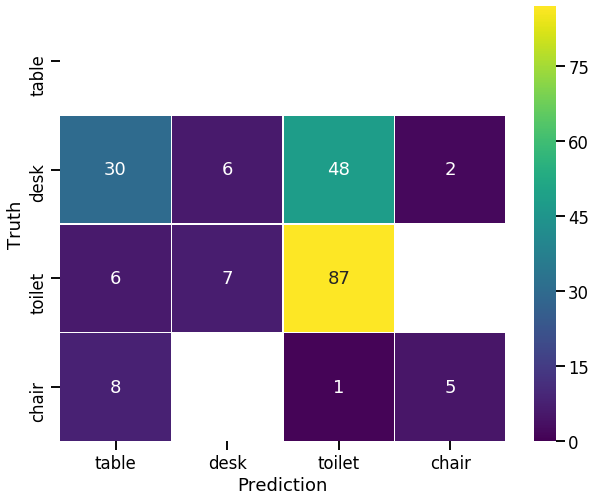

In [0]:
from sklearn import metrics
import seaborn as sns
from ipywidgets import interact
import matplotlib.pyplot as plt
sns.set_context('talk')
palette = sns.color_palette(n_colors=6)

cm = metrics.confusion_matrix(val_df.ground_truth, val_df.prediction)
confusionMatrix = pd.DataFrame(cm, index=l_idx, columns=l_idx)
plt.figure(figsize=(10, 8))

sns.heatmap(confusionMatrix, vmin=0, annot=True, fmt="d", linewidth=.5, mask=(confusionMatrix==0), cmap="viridis")
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.ylim(4, 0)